In [1]:
rlapy_path=''
# insert at 1, 0 is the script path (or '' in REPL)
import sys
#sys.path.insert(0, rlapy_path)
import rlapy as rla
import rlapy.utils.linalg_wrappers as law

This notebook shows a procedural API for an Hermitian eigen-decomposition problem. The driver accepts data A,  and a targeted rank k, a epsilon tolerance "epsilon", an auxiliary parameter s inherited from QBDecomposer/RangeFinder, and a random seed.

The driver checks the if the matrix is Hermitian (i.e., symmetric for real matrices)
 * The first randomized eigen-decomposition algorithm works for Hermitian matrices and follows from Algotihm evd1, based on QBDecomposer
``
EVDecomposer: adapted from the QB-based [HMT11, Algorithm 5.3]
function EVD1(A, k, epsilon, s)
Defining subroutines: QBDecomposer.
Q, B = QBDecomposer(A, k + s, epsilon)
C = BQ # B = Q ∗ A is essential here!
d = number of columns in Q # d <= k + s
U, λ = eigh(C) # Full d × d Hermitian eigendecomposition
r = min{k, d}
I = argmax(|λ|; r) # indices of r largest components of |λ|
U = U[: , I]
λ = λ[I]
V = QU
return V, λ
``

***Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp."Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions."***
 * The second randomized eigen-decomposition algorithm works for *PSD* Hermitian matrices and follows from Algotihm evd2, based on RangeFinder
``
EVDecomposer: psd matrices only, [TYUC17a, Algorithm 3]
function EVD2(A, k, NaN, s)
Defining subroutines: RowSketcher
S = RowSketcher(A, k + s)
Y = AS
ν = n sqrt(eps_mach)||Y|| # a temporary regularization parameter
Y = Y + nu*S
R = chol(S ∗ Y) # R is upper-triangular and R ∗ R = S ∗ Y = S ∗ (A + νI)S
B = Y(R^*)^{−1} # B has n rows and k + s columns
V, Σ, W^* = svd(B)
r = min {k} ∪ {i < k | Σ _{(i+1)(i+1)} \leq nu} # drop components that relied on regularization
λ = (Σ^2_{1,1} − nu, . . . , Σ^2_{r,r} − nu)
V = V[: , : r].
return V, λ
``

***Joel A Tropp, Alp Yurtsever, Madeleine Udell, and Volkan Cevher."Fixed-rank approximation of a positive-semidefinite matrix from streaming data."Advances in neural information processing systems, 2017.***

(80, 80)


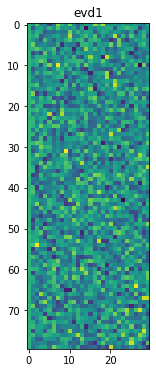

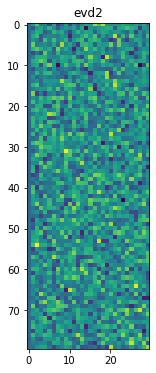

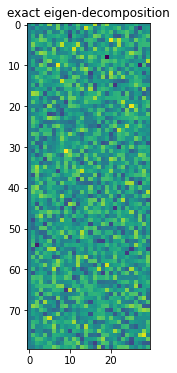

In [6]:
from rlapy.comps.evd import *
A0 = np.random.uniform(size=(40,80))
A0 = A0.T @ A0
print(A0.shape)
import matplotlib.pyplot as plt
target_rank = 30
#The evd1 method works for Hermitian matrices
V1,L1 = evd1(num_passes=2, A=A0, k=target_rank, epsilon=0.1, s=2, rng=123)
plt.figure(figsize=(6,6))
plt.imshow(V1)
plt.title('evd1')
plt.show()

#The evd1 method works for Hermitian matrices
V2,L2 = evd2(num_passes=3, A=A0, k=target_rank, epsilon=.1, s=2, rng=123)
plt.figure(figsize=(6,6))
plt.imshow(V2)
plt.title('evd2')
plt.show()

#Now, let us check the results from rlapy against an exact SVD factorization
from scipy.linalg import svd, eigh
U0,L0,Vh0 = svd(A0)
W0, V = eigh(A0)
plt.figure(figsize=(6,6))
plt.imshow(U0[:,range(target_rank)])
plt.title('exact eigen-decomposition')
plt.show()
#la.norm(A0)

#print('eigen values:')
#print(L0,'\n',L1,'\n',L2)